# Derma - Care

## Skin Disease Detector
### Currently, I am going to handle the following 4 skin diseases,
1. Acne
2. Vitiligo
3. Chicken Pox
4. Eczema

## Import python libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [31]:
from tensorflow.keras.metrics import Precision, Recall, Accuracy

In [4]:
import cv2
import imghdr

## Limit memory growth to avoid any runtime error

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Filter suspicious images

In [5]:
data_dir = 'data'

### Image types to include (list of supported extensions)

In [6]:
image_ext = ['jpeg', 'jpg', 'bmp', 'png']

### Iterate through each directory inside our main data directory and filter for the images with supported extensions

In [7]:
for image_class in os.listdir(data_dir):
    try:
        for image in os.listdir(os.path.join(data_dir, image_class)):
            image_path = os.path.join(data_dir, image_class, image)
            try:
                img = cv2.imread(image_path)
                tip = imghdr.what(image_path)
                if tip not in image_ext:
                    print('Image not in extension list {}'.format(image_path))
                    os.remove(image_path)
            except:
                print('Issue with image {}'.format(image_path))
    except:
        pass

Image not in extension list data/acne/.DS_Store
Image not in extension list data/eczema/.DS_Store
Image not in extension list data/vitiligo/.DS_Store
Image not in extension list data/chicken_pox/.DS_Store


## Load Data (Generates a `tf.data.Dataset` from image files in a directory.)

In [8]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 1832 files belonging to 4 classes.
Metal device set to: Apple M2


2023-03-14 21:35:41.272928: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-14 21:35:41.273450: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Convert all elements of the dataset to numpy.(Returns an iterator)

In [9]:
data_iterator = data.as_numpy_iterator()

In [10]:
data_iterator

In [11]:
batch = data_iterator.next()

2023-03-14 21:35:47.812317: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [12]:
len(batch)

2

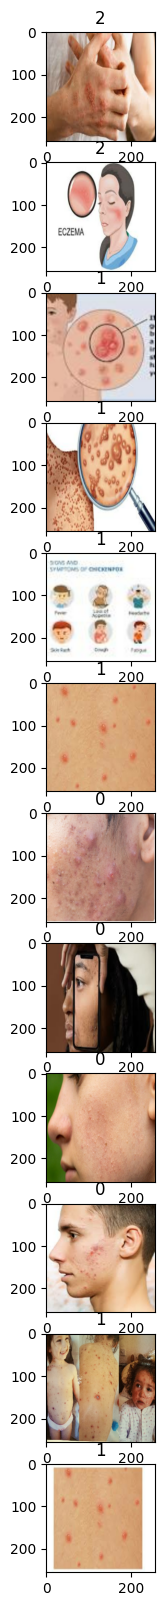

In [13]:
fig, ax = plt.subplots(nrows=12, figsize=(20,20))
for idx, img in enumerate(batch[0][:12]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## Data Labels
* acne - 0
* chicken pox - 1
* eczema - 2
* vitiligo - 3

## Data Scaling (to make the neural model optimize quickly and find the global minima)

In [14]:
batch[0].min(), batch[0].max()

(0.0, 255.0)

In [15]:
data = data.map(lambda x,y: (x/255, y))

In [16]:
data.as_numpy_iterator().next()

(array([[[[0.28904718, 0.5596354 , 0.54002756],
          [0.29120585, 0.56963724, 0.5461078 ],
          [0.2866136 , 0.565045  , 0.5415156 ],
          ...,
          [0.42660078, 0.6658165 , 0.63444394],
          [0.41568628, 0.654902  , 0.62352943],
          [0.41960785, 0.65882355, 0.627451  ]],
 
         [[0.2957414 , 0.56977636, 0.54844517],
          [0.2992302 , 0.5776616 , 0.55413216],
          [0.29352158, 0.571953  , 0.5484235 ],
          ...,
          [0.419807  , 0.6590227 , 0.62765014],
          [0.41568628, 0.654902  , 0.62352943],
          [0.41960785, 0.65882355, 0.627451  ]],
 
         [[0.29861367, 0.577045  , 0.5535156 ],
          [0.3019608 , 0.5803922 , 0.5568628 ],
          [0.29776347, 0.5761949 , 0.5526654 ],
          ...,
          [0.409868  , 0.6490837 , 0.6177111 ],
          [0.41568628, 0.654902  , 0.62352943],
          [0.41960785, 0.65882355, 0.627451  ]],
 
         ...,
 
         [[0.97855324, 0.97855324, 0.97855324],
          [0.98990

## Train - Validation - Test Split

In [17]:
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2)
test_size = int(len(data) * 0.1)

In [18]:
train_size, val_size, test_size

(40, 11, 5)

In [19]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [20]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Build Deep Learning Model

### Model Architecture

In [39]:
model = Sequential()

In [40]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [41]:
model.compile('adam', loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

## Train Model

In [43]:
logdir='logs'

In [44]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [45]:
history = model.fit(train, epochs=50, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/50


2023-03-14 21:46:41.235253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - ETA: 0s - loss: 1.3861 - accuracy: 0.3133

2023-03-14 21:46:45.144525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 7s 140ms/step - loss: 1.3861 - accuracy: 0.3133 - val_loss: 1.2933 - val_accuracy: 0.3892
Epoch 2/50
40/40 [==============================] - 6s 139ms/step - loss: 1.2773 - accuracy: 0.4102 - val_loss: 1.2482 - val_accuracy: 0.4347
Epoch 3/50
40/40 [==============================] - 6s 136ms/step - loss: 1.1219 - accuracy: 0.5336 - val_loss: 1.1194 - val_accuracy: 0.5398
Epoch 4/50
40/40 [==============================] - 6s 135ms/step - loss: 0.8990 - accuracy: 0.6430 - val_loss: 0.9537 - val_accuracy: 0.6335
Epoch 5/50
40/40 [==============================] - 6s 136ms/step - loss: 0.6366 - accuracy: 0.7789 - val_loss: 0.9557 - val_accuracy: 0.6506
Epoch 6/50
40/40 [==============================] - 6s 136ms/step - loss: 0.4460 - accuracy: 0.8539 - val_loss: 0.7992 - val_accuracy: 0.6932
Epoch 7/50
40/40 [==============================] - 6s 135ms/step - loss: 0.3510 - accuracy: 0.8898 - val_loss: 1.1501 - val_accuracy: 0.6705
Epoch 8/50
40/40 

## Performance Plot

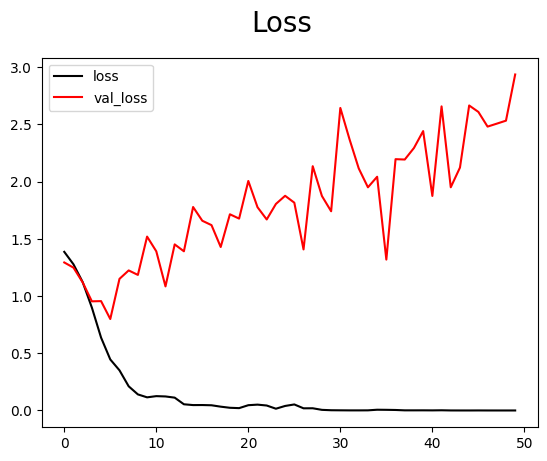

In [46]:
fig = plt.figure()
plt.plot(history.history['loss'], color='black', label='loss')
plt.plot(history.history['val_loss'], color='red', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend()
plt.show()

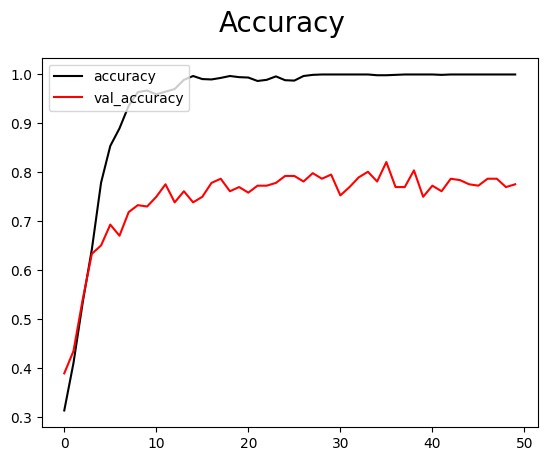

In [47]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='black', label='accuracy')
plt.plot(history.history['val_accuracy'], color='red', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### (Note - We can clearly observe from the above loss and accuracy plots that our model is overfitting a lot.)

## Model Evaluation

In [32]:
P = Precision()
R = Recall()
A = Accuracy()

In [33]:
for batch in test.as_numpy_iterator():
    X, y = batch
    # print('y:',y)
    yhat = model.predict(X)
    yhat_mod = [list(item).index(item.max()) for item in yhat]
    # print('yhat_mod:',yhat_mod)
    # print('yhat:',yhat)
    P.update_state(y, yhat_mod)
    R.update_state(y, yhat_mod)
    A.update_state(y, yhat_mod)

1/1 [==============================] - 0s 90ms/step


2023-03-14 21:39:32.503773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 22ms/step


## Result

In [34]:
print("Precision:", P.result().numpy() * 100, "\nRecall:"
      , R.result().numpy() * 100
      , "\nAccuracy:", A.result().numpy() * 100)

Precision: 86.56716346740723 
Recall: 95.0819730758667 
Accuracy: 68.75


## Test model on direct Image input

In [48]:
def skin_disease_detector(dl_model, image_path):
    """
    Step 0 : Get image path
    Step 1 : Read image
    Step 2 : Show the input image in RGB
    Step 3 : Resize the image
    Step 4 : Scale the image to match the model input format
    Step 5 : Run the model on the input
    Step 6 : Identify the label as per models prediction
    """
    img = cv2.imread(image_path)
    print("Input image:")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    
    test_image = tf.image.resize(img, (256,256))
    yhat = dl_model.predict(np.expand_dims(test_image/255, 0))
    yhat_mod = [list(item).index(item.max()) for item in yhat]
    
    print('Model Predictions:')
    if yhat_mod[0] == 0:
        print("\nTest image is Acne")
    elif yhat_mod[0] == 1:
        print("\nTest image is Chicken Pox")
    elif yhat_mod[0] == 2:
        print("\nTest image is Eczema")
    else:
        print("\nTest image is Vitiligo")

In [36]:
os.listdir('data/vitiligo')

['images296.jpg',
 'images282.jpg',
 'images255.jpg',
 'images26.jpg',
 'images241.jpg',
 'images32.jpg',
 'images269.jpg',
 '9a0933.jpg',
 'Vitiligo_-Symptoms-Causes-and-Treatment.jpg',
 'vililigo-1656496689.jpg',
 'image22.jpeg',
 'images123.jpg',
 'images137.jpg',
 'images321.jpg',
 'vitiligo-1.jpg',
 'images335.jpg',
 'images334.jpg',
 'images320.jpg',
 'ch1524.fig1_.jpg',
 'images136.jpg',
 'images122.jpg',
 'images268.jpg',
 'images33.jpg',
 'images240.jpg',
 'images27.jpg',
 'images254.jpg',
 'image18.jpeg',
 'vitiligotypes-1024x546.jpg',
 'images283.jpg',
 'images297.jpg',
 'images295.jpg',
 'images31.jpg',
 'images25.jpg',
 'images19.jpg',
 'images134.jpg',
 'images120.jpg',
 'images108.jpg',
 'images336.jpg',
 'images322.jpg',
 'images323.jpg',
 'images337.jpg',
 'images109.jpg',
 'images121.jpg',
 'images135.jpg',
 'le-vitiligo-peau-perd-pigment-big.jpg',
 'images18.jpg',
 'images257.jpg',
 'images24.jpg',
 'images30.jpg',
 'image14.jpeg',
 'images294.jpg',
 'images280.jpg',

Input image:


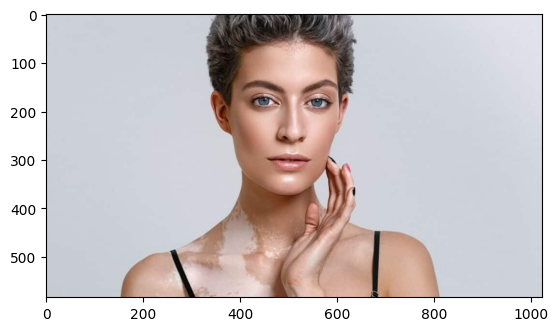

1/1 [==============================] - 0s 12ms/step
Model Predictions:

Test image is Vitiligo


In [38]:
skin_disease_detector(model, 'data/vitiligo/Vitiligo3.jpeg')

# The END?